# Loss Landscape (1-dim)

In [1]:
import jax.numpy as np
from jax import grad, jit, vmap, random, jacfwd, jacrev
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm

from svgd import SVGD
from metrics import ksd
import time

cpu


/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
n=100
d=1
stepsize = 0.01
svgd_stepsize = stepsize
n_iter_max = 500 # 100 slightly to little, this should be all right
# grid_length = 25
# bandwidth = 1

from jax.scipy.stats import norm

@jit
def logp(x):
    assert x.ndim == 1
    return np.sum(norm.logpdf(x, loc=0, scale=1)) 

from svgd import get_bandwidth

svgd_fix = SVGD(logp=logp, n_iter_max=n_iter_max, adaptive_kernel=False, get_bandwidth=None, particle_shape=(n, d))
svgd_ada = SVGD(logp=logp, n_iter_max=n_iter_max, adaptive_kernel=True,  get_bandwidth=get_bandwidth, particle_shape=(n, d))

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


# Define plotting utilities

In [3]:
def sweep(rkey, grid, sample_each_time=False, joint_param=False, average_over=1):
    """Sweep a grid of bandwidth values and output corresponding metrics.
    Arguments:
    * average_over: integer, compute average over m random seeds
    """
    if average_over == 1:
        sweep_results = []
        if sample_each_time:
            rkeys = random.split(svgd_fix.rkey, len(grid))
        else:
            rkeys = [rkey] * len(grid)

        for rkey, h in tqdm(zip(rkeys, grid)):
            if joint_param:
                l = svgd_fix.loss(rkey, h, h)
#                 gl = jacfwd(svgd_fix.loss, argnums=1)(rkey, h, h)
            else:
                l = svgd_fix.loss(rkey, h)
#                 gl = jacfwd(svgd_fix.loss, argnums=1)(rkey, h)
            
#             if np.isnan(gl):
#                 gl = 0
            sweep_results.append(l)

        sweep_results = np.array(sweep_results)
    else:
        ress = []
        for _ in range(average_over):
            rkey = random.split(rkey)[0]
            res = sweep(rkey, grid, sample_each_time=False, joint_param=joint_param, average_over=1)
            ress.append(res)
        ress = np.array(ress)
        sweep_results = np.mean(ress, axis=0)
    if np.any(np.isnan(sweep_results)): print("NaNs detected!")
    return sweep_results

def makeplots(data, grid, xscale="linear", yscale="linear", style=".", mark_ada=True):
    plt.figure(1, figsize=[8, 4])
    l = len(data)
    labels = ["loss(h)", "grad(loss)(h)"]
    cols = ["r", "b", "g", "y"]
    
    i=0
    d=data
    plt.plot(grid, d, f"r{style}", color=cols[i])
    plt.xlabel("h")
    plt.ylabel(labels[i])
    plt.yscale(yscale)
    plt.xscale(xscale)
    if i==0 and mark_ada: plt.axhline(y=ksd_ada, color="y")
    
#     for i, d in enumerate(data):
#         plt.subplot(f"{l}1{i+1}")
#         plt.plot(grid, d, f"r{style}", color=cols[i])
#         plt.xlabel("h")
#         plt.ylabel(labels[i])
#         plt.yscale(yscale)
#         plt.xscale(xscale)
#         if i==0 and mark_ada: plt.axhline(y=ksd_ada, color="y")
            
def get_ada_loss(m):
    ksd_ada = []
    for _ in tqdm(range(m)):
        svgd_ada.newkey()
        xout_ada, _ = svgd_ada.svgd(svgd_ada.rkey, svgd_stepsize, bandwidth=0, n_iter=n_iter_max)
        ksd_ada.append(ksd(xout_ada, logp, bandwidth=1))
    ksd_ada = np.array(ksd_ada)
    print("variance", np.var(ksd_ada))
    ksd_ada = np.mean(ksd_ada)
    return ksd_ada

# Experiments
## 1
* Plot KSD and grad(KSD) for bandwidths 0, ..., 10.000.
* Optimize bandwidth, initializing at various points along the bandwidth grid.

#### Note
You're gonna get `NaN`s for your gradients as soon as the bandwidth is smaller than 0.25 (the gradient becomes very large). If you really want to, you can set JAX to use doubles,
```
from jax.config import config
config.update("jax_enable_x64", True)
```
in which case NaNs will start appearing once bandwidth is somewhere below 0.1, the gradient growing to something like $10^{259}$ shortly before that.

First: for comparison, compute adaptive SVGD

In [4]:
m = 10
ksd_ada = get_ada_loss(m)

  0%|          | 0/10 [00:00<?, ?it/s]

JIT COMPILING svgd...
...done compiling svgd after 0.4371676445007324 seconds.


100%|██████████| 10/10 [00:15<00:00,  1.60s/it]


variance 3.6785455e-09


In [5]:
grid_len = 70
m = 10

## Overview plot

Stuff happens in the range $[0, 100]$, after that the loss is boringly constant (assuming KSD with kernel bandwidth $h=1$.

In [6]:
rkey = random.PRNGKey(0)
bandwidth_grid = np.logspace(-0.5, 10, num=grid_len)
bandwidth_grid = np.linspace(0.3, 80, num=grid_len)
slog = sweep(rkey, bandwidth_grid, sample_each_time=False, average_over=m)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
0it [00:00, ?it/s]

JIT COMPILING svgd...
...done compiling svgd after 0.1466975212097168 seconds.


70it [00:13,  5.21it/s]
70it [00:07,  9.56it/s] 
70it [00:07,  9.74it/s] 
70it [00:07,  9.39it/s] 
70it [00:07,  9.74it/s] 
70it [00:07,  9.73it/s] 
70it [00:07,  9.73it/s] 
70it [00:07,  9.33it/s] 
70it [00:07,  9.53it/s] 
70it [00:07,  9.66it/s] 


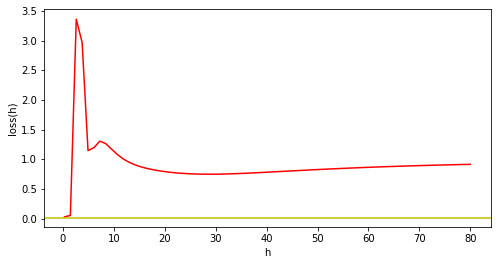

In [7]:
makeplots(slog.transpose(), bandwidth_grid, xscale="linear", style="")

### vary KSD parameter jointly with SVGD parameter

70it [00:08,  7.82it/s] 
70it [00:08,  7.82it/s] 
70it [00:08,  7.82it/s] 
70it [00:09,  7.34it/s] 
70it [00:09,  7.59it/s]
70it [00:09,  7.76it/s] 
70it [00:09,  7.54it/s] 
70it [00:09,  7.52it/s] 
70it [00:08,  7.79it/s]
70it [00:08,  7.81it/s] 


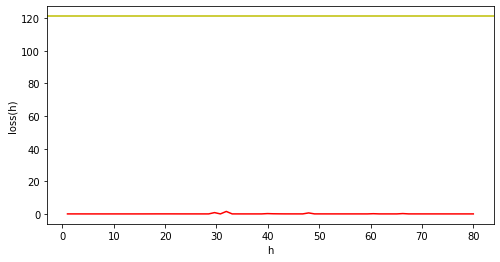

In [22]:
rkey = random.PRNGKey(0)
# bandwidth_grid = np.logspace(-0.5, 10, num=grid_len)
bandwidth_grid = np.linspace(1, 80, num=grid_len)
slogj1 = sweep(rkey, bandwidth_grid, sample_each_time=False, average_over=m, joint_param=True)

makeplots(slogj1.transpose(), bandwidth_grid, xscale="linear", style="")

## Smaller range

In [9]:
rkey = random.PRNGKey(1)
bandwidth_grid = np.linspace(1, 7, num=grid_len) # NaNs when h < 0.25

In [10]:
sl = sweep(rkey, bandwidth_grid, sample_each_time=False, average_over=m)

70it [00:08,  8.73it/s] 
70it [00:07,  9.21it/s] 
70it [00:07,  9.56it/s] 
70it [00:07,  9.42it/s] 
70it [00:07,  9.17it/s] 
70it [00:07,  9.24it/s] 
70it [00:07,  9.11it/s] 
70it [00:07,  8.98it/s] 
70it [00:07,  9.09it/s] 
70it [00:07,  9.43it/s] 


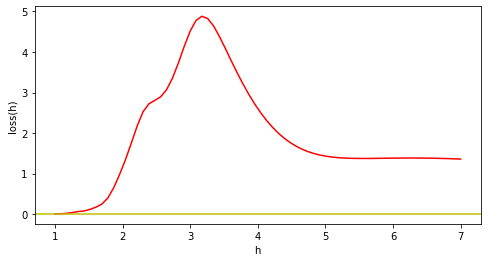

In [11]:
makeplots(sl.transpose(), bandwidth_grid, style="")

### Vary KSD parameter jointly with SVGD parameter

In [12]:
grid_len = 70
rkey = random.PRNGKey(0)
bandwidth_grid = np.linspace(1, 7, num=grid_len) # NaNs when h < 0.25

In [13]:
sjoint = sweep(rkey, bandwidth_grid, joint_param=True, average_over=m)

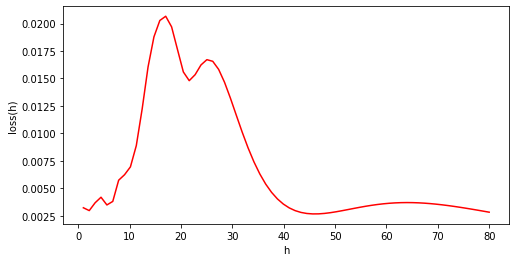

In [23]:
makeplots(sjoint.transpose(), bandwidth_grid, style="", mark_ada=False)

# Same again, with mixture as target

In [14]:
n=100
d=1
stepsize = 0.01
svgd_stepsize = stepsize
n_iter_max = 500 # 100 slightly to little, this should be all right


from utils import log_gaussian_mixture
logp_mix = lambda x: log_gaussian_mixture(x, means=[-2, 2], variances=[1, 1], weights=[1/3, 2/3])

from svgd import get_bandwidth

svgd_fix = SVGD(logp=logp_mix, n_iter_max=n_iter_max, adaptive_kernel=False, get_bandwidth=None, particle_shape=(n, d))
svgd_ada = SVGD(logp=logp_mix, n_iter_max=n_iter_max, adaptive_kernel=True,  get_bandwidth=get_bandwidth, particle_shape=(n, d))

In [15]:
grid_len = 70
m = 10

In [16]:
ksd_ada = get_ada_loss(m)

  0%|          | 0/10 [00:00<?, ?it/s]

JIT COMPILING svgd...
...done compiling svgd after 0.4877002239227295 seconds.


100%|██████████| 10/10 [00:17<00:00,  1.70s/it]


variance 0.72918487


### overview

0it [00:00, ?it/s]

JIT COMPILING svgd...
...done compiling svgd after 0.24266910552978516 seconds.


70it [00:15,  4.55it/s]
70it [00:10,  6.92it/s]
70it [00:09,  7.09it/s]
70it [00:09,  7.48it/s]
70it [00:09,  7.74it/s]
70it [00:09,  7.70it/s]
70it [00:09,  7.70it/s] 
70it [00:09,  7.59it/s]
70it [00:09,  7.76it/s]
70it [00:09,  7.68it/s]


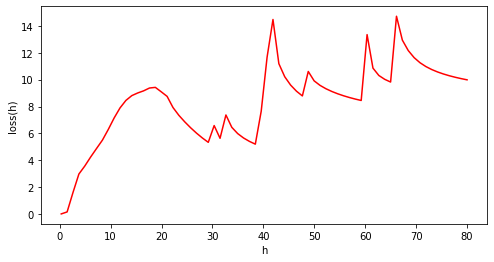

In [17]:
rkey = random.PRNGKey(0)
bandwidth_grid = np.linspace(0.3, 80, num=grid_len)
sov = sweep(rkey, bandwidth_grid, sample_each_time=False, average_over=m)

makeplots(sov.transpose(), bandwidth_grid, xscale="linear", style="", mark_ada=False)

### smaller

70it [00:09,  7.73it/s] 
70it [00:09,  7.77it/s]
70it [00:09,  7.53it/s] 
70it [00:09,  7.53it/s]
70it [00:09,  7.33it/s]
70it [00:10,  6.93it/s]
70it [00:09,  7.12it/s]
70it [00:09,  7.58it/s]
70it [00:09,  7.74it/s]
70it [00:08,  7.79it/s]


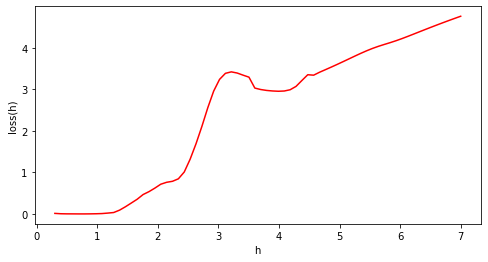

In [18]:
bandwidth_grid = np.linspace(0.3, 7, num=grid_len) # NaNs when h < 0.25
ssmall1 = sweep(rkey, bandwidth_grid, sample_each_time=False, average_over=m)
makeplots(ssmall1.transpose(), bandwidth_grid, xscale="linear", style="", mark_ada=False)

## vary jointly

In [19]:
rkey = random.PRNGKey(1)

### overview (jointly)

70it [00:09,  7.01it/s]
70it [00:09,  7.21it/s] 
70it [00:09,  7.38it/s]
70it [00:09,  7.29it/s]
70it [00:09,  7.62it/s]
70it [00:09,  7.66it/s]
70it [00:09,  7.59it/s]
70it [00:09,  7.44it/s] 
70it [00:09,  7.47it/s]
70it [00:09,  7.76it/s]


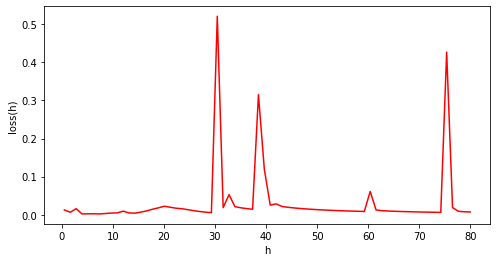

In [20]:
bandwidth_grid = np.linspace(0.5, 80, num=grid_len) # NaNs when h < 0.25
sovj = sweep(rkey, bandwidth_grid, sample_each_time=False, average_over=m, joint_param=True)
makeplots(sovj.transpose(), bandwidth_grid, xscale="linear", style="", mark_ada=False)

### smaller (jointly)

70it [00:09,  7.08it/s]
70it [00:09,  7.19it/s]
70it [00:09,  7.40it/s]
70it [00:09,  7.64it/s] 
70it [00:09,  7.46it/s]
70it [00:09,  7.65it/s]
70it [00:09,  7.73it/s] 
70it [00:09,  7.47it/s] 
70it [00:09,  7.55it/s]
70it [00:08,  7.78it/s] 


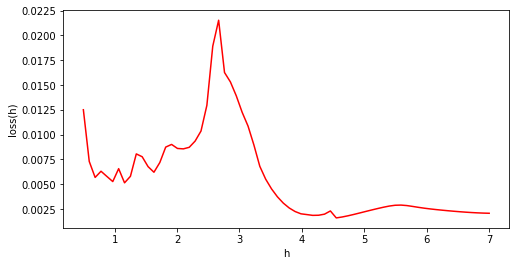

In [21]:
bandwidth_grid = np.linspace(0.5, 7, num=grid_len) # NaNs when h < 0.25
ssmallj = sweep(rkey, bandwidth_grid, sample_each_time=False, average_over=m, joint_param=True)

makeplots(ssmallj.transpose(), bandwidth_grid, xscale="linear", style="", mark_ada=False)